In [3]:
from ase.build import bulk, make_supercell
import numpy as np

from HopDec.ASE import *
from HopDec.Input import *
from HopDec.Lammps import *
from HopDec.State import *

import HopDec.Redecorate as Redecorate
import HopDec.Dimer as Dimer
import HopDec.Minimize as Minimize
import HopDec.NEB as NEB
import HopDec.MD as MD

%matplotlib inline
import matplotlib.pyplot as plt

# Generate Initial Structure (Vacancy in Pure Cu)

In [4]:
# Generate simple ASE structure

CuPrim = bulk('Cu', 'fcc', a=3.6, cubic=True)
CuPrim.cell
CuSuperCell = make_supercell(CuPrim, np.array([[5,0,0],[0,5,0],[0,0,5]]))

In [5]:
# Create Vacancy in supercell

del CuSuperCell[249]

In [6]:
CuSuperCell

Atoms(symbols='Cu499', pbc=True, cell=[18.0, 18.0, 18.0])

# Pass to Hop Dec

In [7]:
params = getParams()

In [8]:
# Initialize HopDec and transform ASE structure to State object

ase = ASE(params)
initialState = ase.toState(CuSuperCell)
initialState

In [7]:
initialState.NAtoms

499

In [9]:
initialState.writeState('init.dat')

In [9]:
# mininize State in-place

lmp = LammpsInterface(params)
Minimize.main(initialState, lmp, params, verbose = True)

[21/02/24, 12:24:07]:   Lammps >> Minimizing. F Tol: 1e-05.
[21/02/24, 12:24:07]: Lammps >> Completed Minimization, E: -1764.8919 eV


In [10]:
initialState.writeState('0.dat')

# Find Transition

In [11]:
flag = 0
while not flag:
    _, newState, flag = MD.main(initialState, params)

[21/02/24, 12:24:25]: MD >> Transition detected in state: 


In [13]:
newState.writeState('1.dat')

In [14]:

connection = NEB.main(initialState, newState, params, exportStructures = True, plotPathways = True, verbose = True) # run a NEB between these two states

[21/02/24, 12:25:03]: NEB >> Minimizing End Points
[21/02/24, 12:25:03]:   Lammps >> Minimizing. F Tol: 1e-05.
[21/02/24, 12:25:03]: Lammps >> Completed Minimization, E: -1764.8919 eV
[21/02/24, 12:25:03]:   Lammps >> Minimizing. F Tol: 1e-05.
[21/02/24, 12:25:03]: Lammps >> Completed Minimization, E: -1764.8919 eV
[21/02/24, 12:25:03]: NEB >> Initializing ASE Structure
[21/02/24, 12:25:03]: NEB >> Interpolating 11 images
[21/02/24, 12:25:03]: NEB >> Performing NEB. Force Tol: 0.1, Transition:
        ab2d71d992015e18300c2bc311585706 -> ab2d71d992015e18300c2bc311585706
[21/02/24, 12:25:04]: NEB >> NEB finished Successfully. Extracting Results
[21/02/24, 12:25:04]: NEB >> Checking NEB path for integrity
[21/02/24, 12:25:04]: Transitions >> Results:
	    Forward Energy Barrier: 0.7411 eV, Rate at 1000 K: 1.364259e-04 1/s
            Reverse Energy Barrer: 0.7411 eV, Rate at 1000 K: 1.364259e-04 1/s
            KRA: 0.7411 eV
            dE: -0.0 eV 


In [15]:
connection.transitions[0].forwardBarrier

0.7411

# Redecorate Transition

In [59]:
# Given that we have found a valid Connection / Transition.
# We may want to run a redecoration campaign
# This one will take the States defined and conduct 10 NEBS (controlled in config file) 
# with redecoration of the atoms as either Cu or Ni at 50:50 concentrations (controlled in config file).
# Then return a results object
params.nDecorations = 2
redecResults = Redecorate.main(connection.transitions[0].initialState, connection.transitions[0].finalState, params, pickle = True)


[21/02/24, 11:29:09]: Redecorate >> Starting NEB Redecoration Campaign
[21/02/24, 11:29:09]:   Redecorate >> rank: 0: Redecoration: 1
[21/02/24, 11:29:10]:   Redecorate >> rank: 0: Redecoration: 2


In [24]:
# The redecoration results contains 10 'Connection'.
# These 'connections' can be thought of as different decorations of the initial connection.

len(redecResults.connections)

2

In [26]:
params.concentration

[0.5, 0.5]

In [60]:
# So we can look at how the KRA and dE vary as a function of the specific decoration.
# It may be the case that while the connection in the pure Cu case has one barrier.
# a specific decoration of that transition is multi-barrier.
# In that case, that decoration will have > 1 transition within it's connection object.

redecResults.summarize()


[21/02/24, 11:29:18]: Redecorate >> Summary:
	Connection 1:
		Transition 1:
			transition.KRA = 0.7426
			transition.dE = -0.1553
	Connection 2:
		Transition 1:
			transition.KRA = 0.8083
			transition.dE = -0.0765


In [61]:
# the results object also contains the States of the redecorations
# In particular, this is the first redecoration and the first transition within that decoration.

redecResults.connections[0].transitions[0].initialState
redecResults.connections[0].transitions[0].finalState
redecResults.connections[0].transitions[0].saddleState
# redecResults.connections[0].transitions[0].initialState.type

# Calculate Barrier as a Function of Cu:Ni Ratio

In [64]:
params = getParams()
initialState = readStateLAMMPSData('0.dat')
finalState = readStateLAMMPSData('1.dat')

In [65]:
lmp = LammpsInterface(params)
minDistInit = lmp.minimize(initialState, verbose = True)
minDistFin = lmp.minimize(finalState, verbose = True)

[21/02/24, 11:32:03]:   Lammps >> Minimizing. F Tol: 1e-05.
[21/02/24, 11:32:03]: Lammps >> Completed Minimization, E: -1764.8919 eV
[21/02/24, 11:32:03]:   Lammps >> Minimizing. F Tol: 1e-05.
[21/02/24, 11:32:03]: Lammps >> Completed Minimization, E: -1764.8919 eV


In [66]:
# Cu_{x}Ni_{1-x}
xVals = [1,0.75,0.5,0.25,0]
results  = []
for x in xVals:

    print(f'Cu: {x}, Ni: {1-x}')

    params.nDecorations = 5
    params.activeSpecies = ['Cu','Ni']
    params.staticSpecies = []
    params.concentration = [x, 1-x]

    Red = Redecorate.main(initialState, finalState, params , comm = None, pickle = True)

    results.append(np.mean([ trans.forwardBarrier for conn in Red.connections for trans in conn.transitions  ]))

Cu: 1, Ni: 0
[21/02/24, 11:33:24]: Redecorate >> Starting NEB Redecoration Campaign
[21/02/24, 11:33:24]:   Redecorate >> rank: 0: Redecoration: 1
[21/02/24, 11:33:25]:   Redecorate >> rank: 0: Redecoration: 2
[21/02/24, 11:33:26]:   Redecorate >> rank: 0: Redecoration: 3
[21/02/24, 11:33:27]:   Redecorate >> rank: 0: Redecoration: 4
[21/02/24, 11:33:28]:   Redecorate >> rank: 0: Redecoration: 5
Cu: 0.75, Ni: 0.25
[21/02/24, 11:33:28]: Redecorate >> Starting NEB Redecoration Campaign
[21/02/24, 11:33:28]:   Redecorate >> rank: 0: Redecoration: 1
[21/02/24, 11:33:29]:   Redecorate >> rank: 0: Redecoration: 2
[21/02/24, 11:33:31]:   Redecorate >> rank: 0: Redecoration: 3
[21/02/24, 11:33:32]:   Redecorate >> rank: 0: Redecoration: 4
[21/02/24, 11:33:34]:   Redecorate >> rank: 0: Redecoration: 5
Cu: 0.5, Ni: 0.5
[21/02/24, 11:33:35]: Redecorate >> Starting NEB Redecoration Campaign
[21/02/24, 11:33:35]:   Redecorate >> rank: 0: Redecoration: 1
[21/02/24, 11:33:36]:   Redecorate >> rank: 0

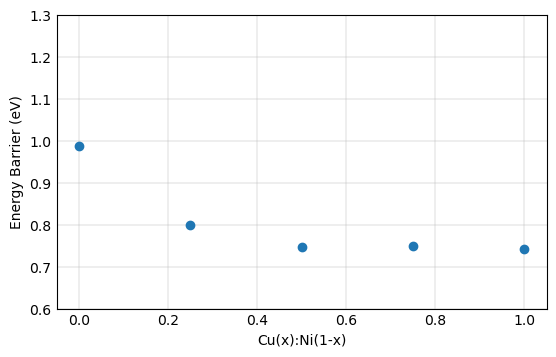

In [67]:
fig, axs = plt.subplots(1,1, figsize = (5,3))

axs.scatter(xVals, results)
axs.set_xlabel('Cu(x):Ni(1-x)')
axs.set_ylabel('Energy Barrier (eV)')
axs.set_ylim([0.6,1.3])

axs.grid(True, linewidth=0.3)